# 利用卷积神经网络进行实时的图像分类

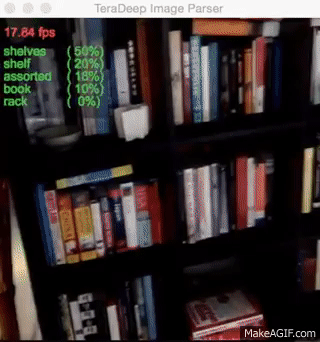
<center>*TeraDeep在NVIDIA Jetson TK1上实现的实时图像分类器*</center>

图中所展示的实时图像分类器是TeraDeep移植在PC上的APP，原项目使用了部署在基于ARM架构的NVIDIA Jetson TK1上。该程序使用videodev2来获取视频数据，逐帧将视频流数据作为训练好的卷积神经网络模型的图片输入；得出预测结果后，再利用OpenGL实现可视化输出。
但是这样实现相对麻烦，毕竟OpenCV已经给我提供了获取视频流数据和可视化结果的接口，所以我们讲使用OpenCV + Keras来实现实时分类器。

## Requirements
- Keras 2.0 or above
- TensorFlow-GPU 1.2 or above
- OpenCV 3
- CUDA 8
- cuDNN 6

##  Steps
1. 基于cifar10数据集，搭建秉训练一个简单的卷积神经网络模型；
2. 利用OpenCV获取视频流数据，作为模型的输入，得到输出，即图像类别；
3. 可视化输出结果

## 模型的搭建与训练


In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


定义模型的部分超参数。batch_size定义了训练时每个mini-batch的大小，num_classes是数据集中对应的物体类别总共有多少种，epochs是魔性训练需要迭代的次数。调整得好的超参数可以在很大程度上训练出更好的模型。

In [2]:
batch_size = 128
num_classes = 10
epochs = 100

利用Keras自带的API读取cifar10数据集

In [3]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


`cifar10.load_data()`这个函数会在网络上去下载cifar10数据集，在国内就会比较慢。
比如我的输出就是：
> Downloading data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 319488/170498071 [..............................] - ETA: 46:21

自动下载速度太慢，就可以想想怎么手动给Keras下载需要的数据集。通过查看Keras源代码中[cifar10.py](https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py) 的可以发现如下代码：

    ...
    from ..utils.data_utils import get_file
    ...
    dirname = 'cifar-10-batches-py'
    origin = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)
    
再来到[data_utils.py](https://github.com/fchollet/keras/blob/master/keras/utils/data_utils.py#L133)的133行，可以看到`get_file()`函数有相当详细的说明：
> Downloads a file from a URL if it not already in the cache. By default the file at the url `origin` is downloaded to the cache_dir `~/.keras`, placed in the cache_subdir `datasets`, and given the filename `fname`. The final location of a file `example.txt` would therefore be `~/.keras/datasets/example.txt`. Files in tar, tar.gz, tar.bz, and zip formats can also be extracted. Passing a hash will verify the file after download. The command line programs `shasum` and `sha256sum` can compute the hash.

可以发现，只需要从https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 下载cifar-10-python.tar.gz 并更名为cifar-10-batches-py.tar.gz 并放入~/.keras/datasets/ 下就行了。

In [4]:
def model_v1():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6) 
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model1 = model_v1()

以上模型代码基于Keras作者提供的示例程序[cifar10_cnn.py](https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py)精简。整个模型两个卷积块，每一个卷积块有两个卷积层。模型结构可视化结果如下图。

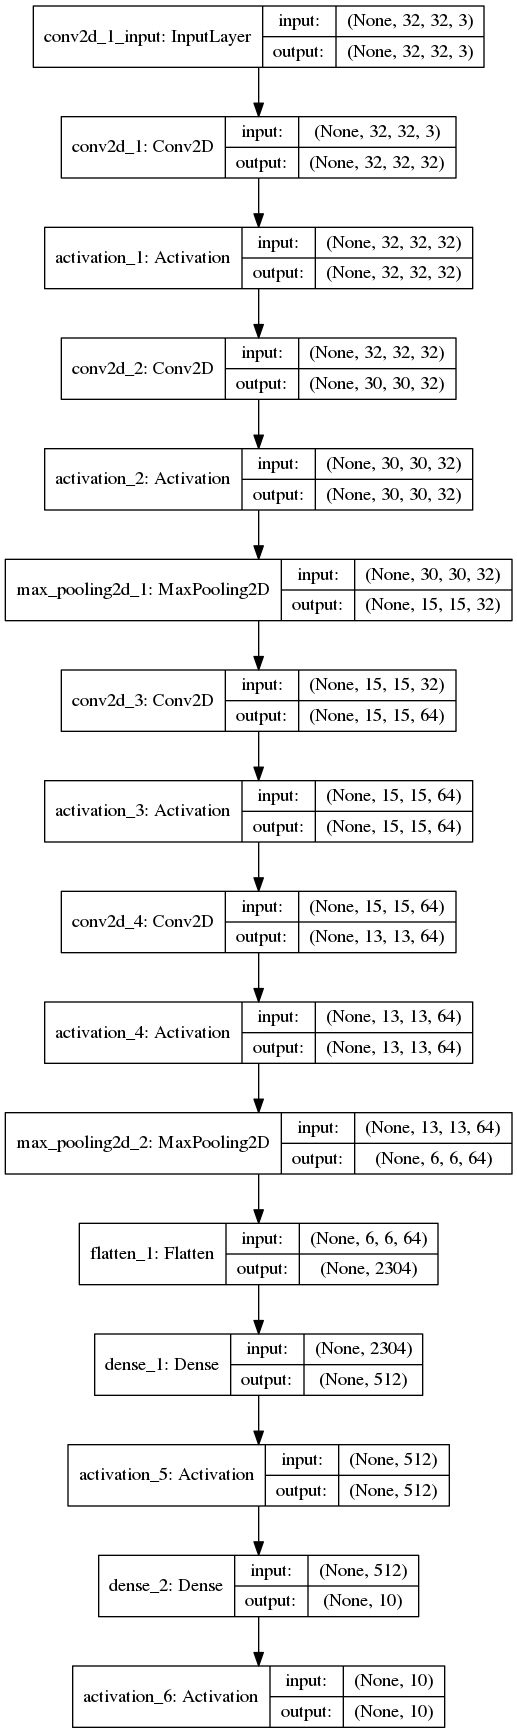

In [5]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (2, 1)
plot_model(model1, to_file='model1.png', show_shapes=True)
Image(filename = 'model1.png')

In [6]:
history_object_model1 = model1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.8203 - acc: 0.3472 - val_loss: 1.6390 - val_acc: 0.4065
Epoch 2/100
50000/50000 [==============================] - 6s 115us/step - loss: 1.5384 - acc: 0.4518 - val_loss: 1.4327 - val_acc: 0.4932
Epoch 3/100
50000/50000 [==============================] - 6s 114us/step - loss: 1.4126 - acc: 0.4994 - val_loss: 1.3399 - val_acc: 0.5294
Epoch 4/100
50000/50000 [==============================] - 6s 115us/step - loss: 1.3186 - acc: 0.5355 - val_loss: 1.2851 - val_acc: 0.5456
Epoch 5/100
50000/50000 [==============================] - 6s 114us/step - loss: 1.2481 - acc: 0.5614 - val_loss: 1.2073 - val_acc: 0.5739
Epoch 6/100
50000/50000 [==============================] - 6s 114us/step - loss: 1.1863 - acc: 0.5849 - val_loss: 1.1657 - val_acc: 0.5847
Epoch 7/100
50000/50000 [==============================] - 6s 114us/step - loss: 1.1330 - acc: 0.6043 - val_loss: 1.

50000/50000 [==============================] - 6s 114us/step - loss: 0.0272 - acc: 0.9931 - val_loss: 1.9938 - val_acc: 0.7021
Epoch 60/100
50000/50000 [==============================] - 6s 115us/step - loss: 0.0282 - acc: 0.9932 - val_loss: 1.9550 - val_acc: 0.7084
Epoch 61/100
50000/50000 [==============================] - 6s 114us/step - loss: 0.0259 - acc: 0.9939 - val_loss: 1.9840 - val_acc: 0.7086
Epoch 62/100
50000/50000 [==============================] - 6s 114us/step - loss: 0.0263 - acc: 0.9932 - val_loss: 2.0256 - val_acc: 0.7075
Epoch 63/100
50000/50000 [==============================] - 6s 115us/step - loss: 0.0219 - acc: 0.9944 - val_loss: 2.0564 - val_acc: 0.7060
Epoch 64/100
50000/50000 [==============================] - 6s 114us/step - loss: 0.0231 - acc: 0.9943 - val_loss: 2.0727 - val_acc: 0.7074
Epoch 65/100
50000/50000 [==============================] - 6s 114us/step - loss: 0.0219 - acc: 0.9944 - val_loss: 2.1377 - val_acc: 0.7019
Epoch 66/100
50000/50000 [=======

In [7]:
model1.save('model1.h5')
#model1.load('model1.h5')

### 训练过程acc变化

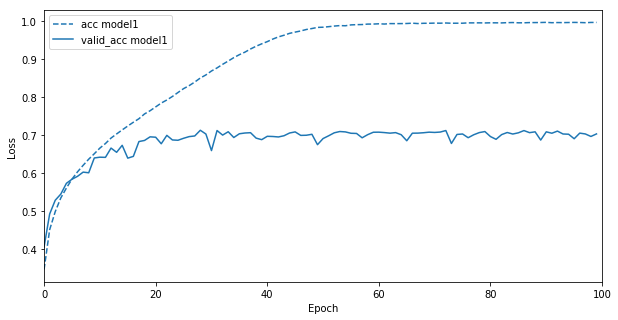

In [78]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history_object_model1.history['acc'], 'C0--')
plt.plot(history_object_model1.history['val_acc'], 'C0')
plt.xlim((0,100))
plt.legend(['acc model1', 'valid_acc model1'])
plt.show()

由图可以看出，该模型方差较大，是很典型的过拟合模型。对于过拟合的模型，我们可以应用多种正则化技术来防止过拟合。目前用的比较多的且最简单的就是Dropout。
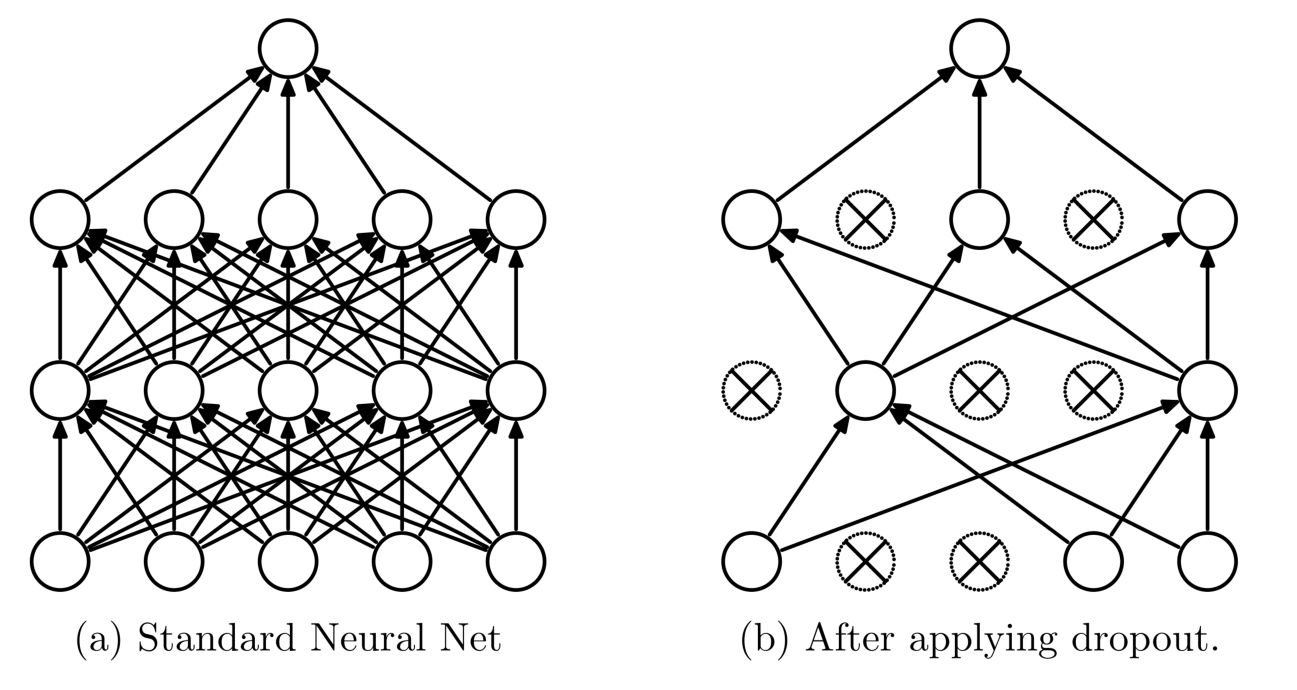
Dropout可以作为一个层添加进神经网络中，dropout会以一个固定的概率随机地断开两层之间地链接，以此来降低过拟合的风险。同时，dropout也是一种集成方法，由于每次训练网络都会随机地断开部分神经元，这就相当于我们一直都在训练许多的子模型。

深度卷积神经网络对于学习率十分敏感，所以通常情况下学习率都调得比较小；随着网络的加深，还会出现梯度消失等问题。此时可以加入batch normalization层来使得模型可以接受更大的学习率，缓解梯度消失问题，同时可能会在一定程度上有正则化的效果。BN的具体算法如下：
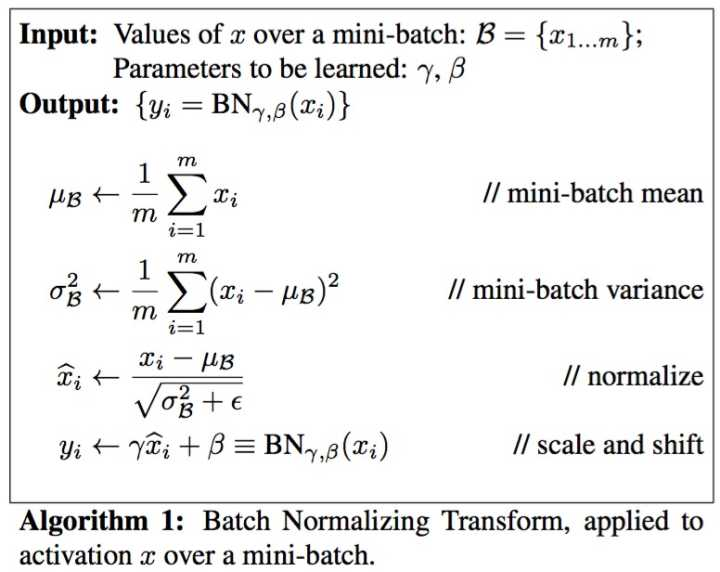

In [9]:
def model_v2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model2 = model_v2()

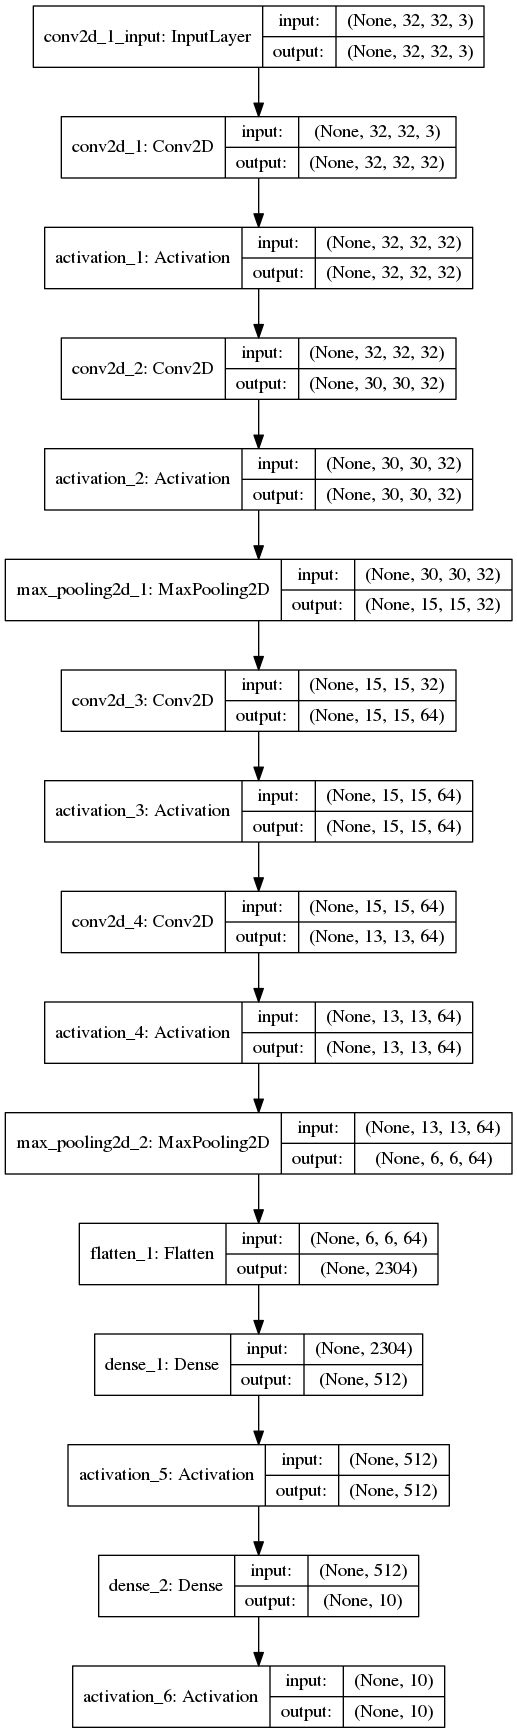

In [10]:
plt.rcParams['figure.figsize'] = (3, 1)
plot_model(model1, to_file='model1.png', show_shapes=True)
Image(filename = 'model1.png')

In [11]:
history_object_model2 = model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 11s 214us/step - loss: 1.7415 - acc: 0.4573 - val_loss: 1.8259 - val_acc: 0.4042
Epoch 2/100
50000/50000 [==============================] - 10s 206us/step - loss: 1.0458 - acc: 0.6331 - val_loss: 1.0432 - val_acc: 0.6496
Epoch 3/100
50000/50000 [==============================] - 10s 208us/step - loss: 0.8435 - acc: 0.7048 - val_loss: 0.7984 - val_acc: 0.7163
Epoch 4/100
50000/50000 [==============================] - 10s 207us/step - loss: 0.7332 - acc: 0.7419 - val_loss: 0.7965 - val_acc: 0.7325
Epoch 5/100
50000/50000 [==============================] - 10s 207us/step - loss: 0.6549 - acc: 0.7696 - val_loss: 0.7172 - val_acc: 0.7581
Epoch 6/100
50000/50000 [==============================] - 10s 207us/step - loss: 0.5963 - acc: 0.7900 - val_loss: 0.6645 - val_acc: 0.7736
Epoch 7/100
50000/50000 [==============================] - 10s 206us/step - loss: 0.5428 - acc: 0.8093 - val_l

50000/50000 [==============================] - 10s 208us/step - loss: 0.1018 - acc: 0.9673 - val_loss: 1.0536 - val_acc: 0.8145
Epoch 59/100
50000/50000 [==============================] - 10s 207us/step - loss: 0.1049 - acc: 0.9660 - val_loss: 1.0152 - val_acc: 0.8092
Epoch 60/100
50000/50000 [==============================] - 10s 208us/step - loss: 0.1007 - acc: 0.9676 - val_loss: 1.0931 - val_acc: 0.8137
Epoch 61/100
50000/50000 [==============================] - 10s 207us/step - loss: 0.1016 - acc: 0.9674 - val_loss: 1.1189 - val_acc: 0.8091
Epoch 62/100
50000/50000 [==============================] - 10s 208us/step - loss: 0.0984 - acc: 0.9687 - val_loss: 1.0180 - val_acc: 0.8058
Epoch 63/100
50000/50000 [==============================] - 10s 207us/step - loss: 0.0945 - acc: 0.9696 - val_loss: 1.0811 - val_acc: 0.8156
Epoch 64/100
50000/50000 [==============================] - 10s 206us/step - loss: 0.0946 - acc: 0.9696 - val_loss: 1.1775 - val_acc: 0.7944
Epoch 65/100
50000/50000 [

In [12]:
model2.save('models/model2.h5')
#model2.load('models/model2.h5')

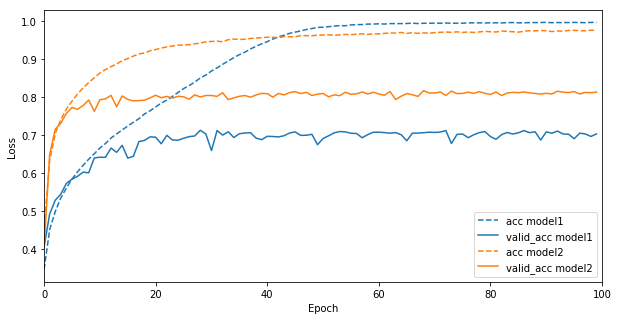

In [79]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history_object_model1.history['acc'], 'C0--')
plt.plot(history_object_model1.history['val_acc'], 'C0')
plt.plot(history_object_model2.history['acc'], 'C1--')
plt.plot(history_object_model2.history['val_acc'], 'C1')
plt.xlim((0,100))
plt.legend(['acc model1', 'valid_acc model1',
            'acc model2', 'valid_acc model2'])
plt.show()

## 尝试其他模型
以上的两个模型都是传统的卷积神经网络模型，他们虽然比传统计算机视觉里的图像分类算法更加优秀，但是依然有着很多明显的缺点。例如，传统的CNN在构建深层模型的时候梯度下降的值会随着模型深度变得很不稳定；不同卷积核大小和数量的选择会在很大程度上影响训练出来的模型的效果，而调出相对好的模型又十分麻烦。

但是，cifar数据集相对于ImageNet数据集，不管是尺寸还是数量上都要小很多，所以在ImageNet上表现不错的模型，如ResNet和Inception等，直接套用起来效果都很差，准确率甚至很难超过model2。

[用Keras训练一个准确率90%+的Cifar-10预测模型](http://nooverfit.com/wp/%E7%94%A8keras%E8%AE%AD%E7%BB%83%E4%B8%80%E4%B8%AA%E5%87%86%E7%A1%AE%E7%8E%8790%E7%9A%84cifar-10%E9%A2%84%E6%B5%8B%E6%A8%A1%E5%9E%8B/)


In [46]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D
from lsuv_init import LSUVinit

def model_v3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(80, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.25))
    #model.add(ZeroPadding2D((1, 1)))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Flatten())
    #model.add(Dropout(0.2))
    '''
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    '''
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # initiate RMSprop optimizer
    opt = keras.optimizers.Adam(lr=0.0001)
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    model = LSUVinit(model,x_train[:batch_size,:,:,:]) 
    return model

model3 = model_v3()

conv2d_24
LSUV initializing conv2d_24
0.0346422
1.0
activation_30
conv2d_25
LSUV initializing conv2d_25
0.048387
1.0
activation_31
conv2d_26
LSUV initializing conv2d_26
0.0451961
1.0
activation_32
conv2d_27
LSUV initializing conv2d_27
0.0219194
1.0
activation_33
conv2d_28
LSUV initializing conv2d_28
0.0197182
1.0
activation_34
max_pooling2d_7
dropout_8
conv2d_29
LSUV initializing conv2d_29
0.0248368
1.0
activation_35
conv2d_30
LSUV initializing conv2d_30
0.0133512
1.0
activation_36
conv2d_31
LSUV initializing conv2d_31
0.0190769
1.0
activation_37
conv2d_32
LSUV initializing conv2d_32
0.015361
1.0
activation_38
conv2d_33
LSUV initializing conv2d_33
0.0141083
1.0
activation_39
max_pooling2d_8
dropout_9
conv2d_34
LSUV initializing conv2d_34
0.0109944
1.0
activation_40
conv2d_35
LSUV initializing conv2d_35
0.00784092
1.0
activation_41
conv2d_36
LSUV initializing conv2d_36
0.00956674
1.0
activation_42
conv2d_37
LSUV initializing conv2d_37
0.00999567
1.0
activation_43
conv2d_38
LSUV initiali

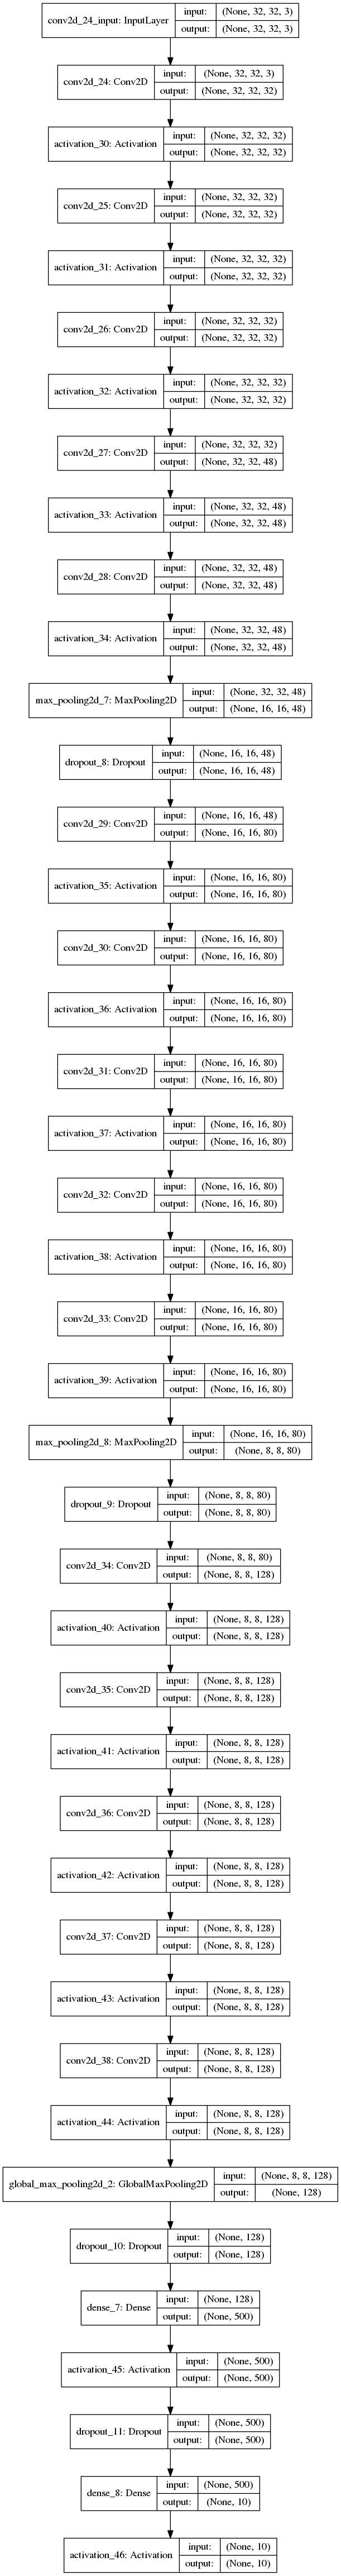

In [47]:
plt.rcParams['figure.figsize'] = (2, 1)
plot_model(model3, to_file='model3.png', show_shapes=True)
Image(filename = 'model3.png')

In [48]:
history_object_model3 = model3.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 21s 415us/step - loss: 2.2436 - acc: 0.1405 - val_loss: 1.8926 - val_acc: 0.3088
Epoch 2/100
50000/50000 [==============================] - 18s 356us/step - loss: 1.8132 - acc: 0.3139 - val_loss: 1.6179 - val_acc: 0.3931
Epoch 3/100
50000/50000 [==============================] - 18s 354us/step - loss: 1.6250 - acc: 0.3950 - val_loss: 1.5682 - val_acc: 0.4241
Epoch 4/100
50000/50000 [==============================] - 18s 357us/step - loss: 1.5077 - acc: 0.4421 - val_loss: 1.4676 - val_acc: 0.4704
Epoch 5/100
50000/50000 [==============================] - 18s 355us/step - loss: 1.4148 - acc: 0.4770 - val_loss: 1.3083 - val_acc: 0.5204
Epoch 6/100
50000/50000 [==============================] - 18s 358us/step - loss: 1.3344 - acc: 0.5139 - val_loss: 1.2929 - val_acc: 0.5316
Epoch 7/100
50000/50000 [==============================] - 18s 358us/step - loss: 1.2630 - acc: 0.5417 - val_l

Epoch 59/100
50000/50000 [==============================] - 18s 358us/step - loss: 0.2940 - acc: 0.8943 - val_loss: 0.6571 - val_acc: 0.8052
Epoch 60/100
50000/50000 [==============================] - 18s 360us/step - loss: 0.2929 - acc: 0.8945 - val_loss: 0.6418 - val_acc: 0.8054
Epoch 61/100
50000/50000 [==============================] - 18s 359us/step - loss: 0.2860 - acc: 0.8967 - val_loss: 0.6595 - val_acc: 0.8055
Epoch 62/100
50000/50000 [==============================] - 18s 355us/step - loss: 0.2804 - acc: 0.9000 - val_loss: 0.6822 - val_acc: 0.8069
Epoch 63/100
50000/50000 [==============================] - 18s 358us/step - loss: 0.2785 - acc: 0.8994 - val_loss: 0.6904 - val_acc: 0.7988
Epoch 64/100
50000/50000 [==============================] - 18s 358us/step - loss: 0.2770 - acc: 0.8996 - val_loss: 0.6659 - val_acc: 0.8007
Epoch 65/100
50000/50000 [==============================] - 18s 356us/step - loss: 0.2659 - acc: 0.9038 - val_loss: 0.7312 - val_acc: 0.7997
Epoch 66/100


In [49]:
model3.save('models/model3.h5')
#model3.load('models/model3.h5')

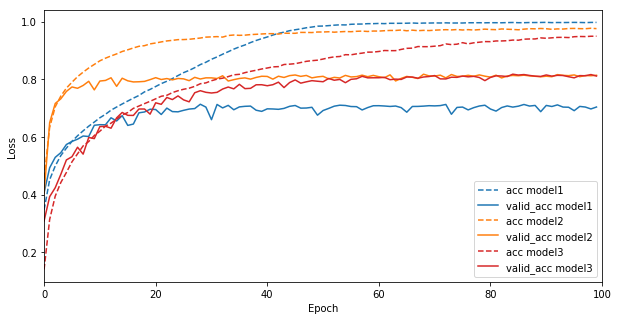

In [80]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history_object_model1.history['acc'], 'C0--')
plt.plot(history_object_model1.history['val_acc'], 'C0')
plt.plot(history_object_model2.history['acc'], 'C1--')
plt.plot(history_object_model2.history['val_acc'], 'C1')
plt.plot(history_object_model3.history['acc'], 'C3--')
plt.plot(history_object_model3.history['val_acc'], 'C3')
plt.xlim((0,100))
plt.legend(['acc model1', 'valid_acc model1',
            'acc model2', 'valid_acc model2',
            'acc model3', 'valid_acc model3'])
plt.show()

### 回归本质：使用MobileNets
虽然我们之前所用的model3有着很大的潜力，但是相对于之前使用的model1和model2，model3显然要庞大得多；而庞大体积的模型就很难做到实时预测，而且会耗费大量的硬件资源。Google提出了一种名为MobileNets的专用于运行在手机这样硬件资源比较紧张的设备上的卷积神经网络：MobileNet部署在2000元以下的手机上，即使CPU使用率小于15%，依然能够做到实时输出。

MobileNets的主要特点是将标准的卷积操作换成了Depthwise convolution和Pointwise convolution，从而使得模型内部两个卷积层之间，即使是在通道上，链接依然是稀疏的。这样一来，模型的运算量就大大降低了。
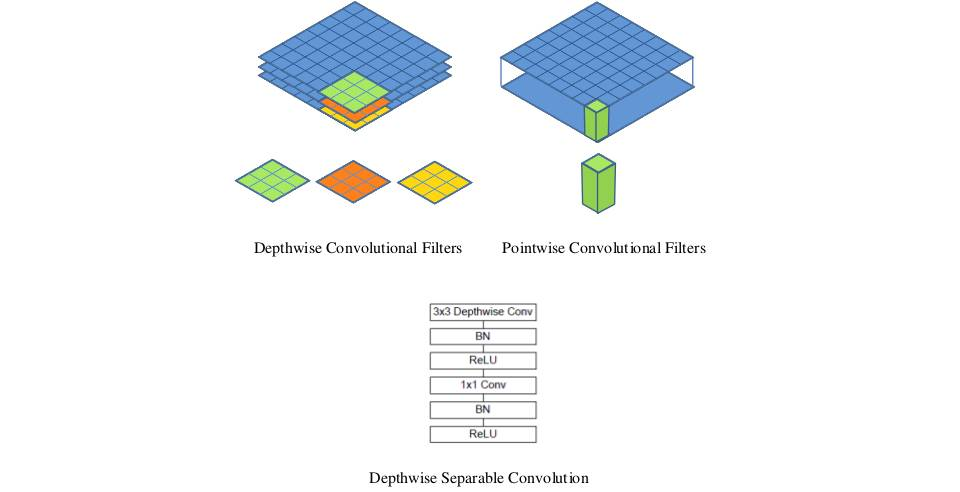

(32, 32, 3)


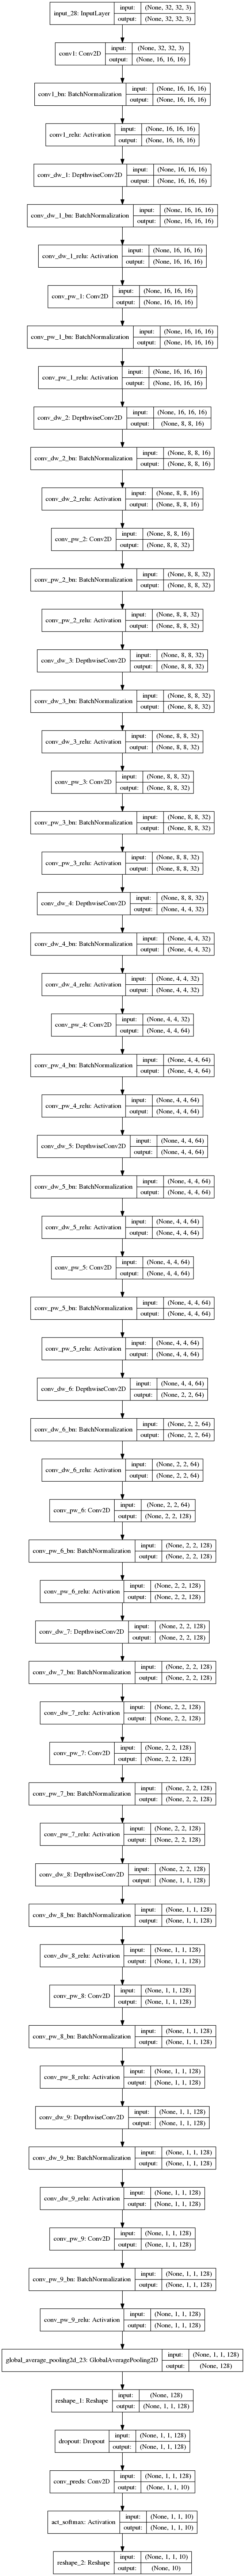

In [70]:
from keras.applications.mobilenet import _depthwise_conv_block, _conv_block
from keras.layers import Input, GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras import backend as K

#m_net = mobilenet.MobileNet(input_shape=x_train.shape[1:], weights=None, classes=10)
def my_mobile_net():
    alpha=1.0
    depth_multiplier=1
    dropout=1e-3
    shape = x_train.shape[1:]
    print(shape)
    img_input = Input(shape=x_train.shape[1:])
    x = _conv_block(img_input, 16, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 16, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 32, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 32, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=7)
    
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=8)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=9)

    if K.image_data_format() == 'channels_first':
        shape = (int(128 * alpha), 1, 1)
    else:
        shape = (1, 1, int(128 * alpha))
    
    rows = shape[0]
    cols = shape[1]
    x = GlobalAveragePooling2D()(x)
    x = Reshape(shape, name='reshape_1')(x)
    x = Dropout(dropout, name='dropout')(x)
    x = Conv2D(num_classes, (1, 1),
               padding='same', name='conv_preds')(x)
    x = Activation('softmax', name='act_softmax')(x)
    x = Reshape((num_classes,), name='reshape_2')(x)
    inputs = img_input
    
    model = Model(inputs, x, name='my_mobilenet')
    return model

m_net = my_mobile_net()
opt = keras.optimizers.Adam()
m_net.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

plt.rcParams['figure.figsize'] = (2, 1)
plot_model(m_net, to_file='m_net.png', show_shapes=True)
Image(filename = 'm_net.png')

In [71]:
history_object_m_net = m_net.fit(x_train, y_train,
          batch_size=64,
          epochs=40,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 32s 639us/step - loss: 2.0828 - acc: 0.2282 - val_loss: 1.8393 - val_acc: 0.3140
Epoch 2/40
50000/50000 [==============================] - 26s 525us/step - loss: 1.7199 - acc: 0.3619 - val_loss: 1.7351 - val_acc: 0.3738
Epoch 3/40
50000/50000 [==============================] - 26s 524us/step - loss: 1.5631 - acc: 0.4253 - val_loss: 1.5044 - val_acc: 0.4405
Epoch 4/40
50000/50000 [==============================] - 26s 521us/step - loss: 1.4504 - acc: 0.4698 - val_loss: 1.6158 - val_acc: 0.4297
Epoch 5/40
50000/50000 [==============================] - 26s 524us/step - loss: 1.3704 - acc: 0.5027 - val_loss: 1.4420 - val_acc: 0.4823
Epoch 6/40
50000/50000 [==============================] - 26s 522us/step - loss: 1.3023 - acc: 0.5299 - val_loss: 1.5834 - val_acc: 0.4398
Epoch 7/40
50000/50000 [==============================] - 26s 521us/step - loss: 1.2436 - acc: 0.5511 - val_loss: 1.

In [82]:
m_net.save('model4.h5')
#m_net.load('model4.h5')

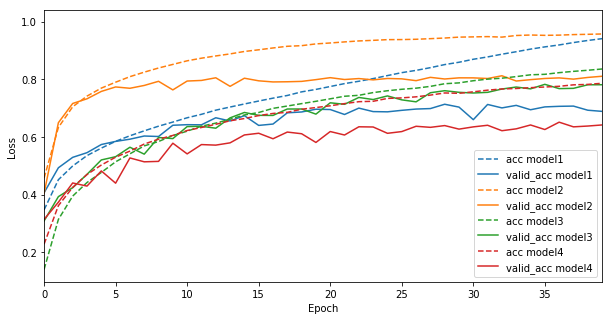

In [81]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history_object_model1.history['acc'], 'C0--')
plt.plot(history_object_model1.history['val_acc'], 'C0')
plt.plot(history_object_model2.history['acc'], 'C1--')
plt.plot(history_object_model2.history['val_acc'], 'C1')
plt.plot(history_object_model3.history['acc'], 'C2--')
plt.plot(history_object_model3.history['val_acc'], 'C2')
plt.plot(history_object_m_net.history['acc'], 'C3--')
plt.plot(history_object_m_net.history['val_acc'], 'C3')
plt.xlim((0,39))
plt.legend(['acc model1', 'valid_acc model1',
            'acc model2', 'valid_acc model2',
            'acc model3', 'valid_acc model3',
            'acc model4', 'valid_acc model4'])
plt.show()

In [86]:
import cv2
import scipy
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
img_shape = (frame.shape[1], frame.shape[1], 3)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

while(True):
    ret, frame = cap.read()
    if ret == 0:
        break
    frame = frame[0:img_shape[1], 0:img_shape[1], :]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame/255
    result = classes[np.argmax(model4.predict(scipy.misc.imresize(frame, [32, 32], interp='lanczos')))]
    cv2.imshow('Classifier',frame)
    print(result)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()

## 其他提高推理速度的策略
### 使用专用于推理的框架
- TenorRT 3。 TensorRT 3 是NVIDIA提供的深度学习推理框架，可以在CUDA GPU上进行模型推理。TensorRT能在牺牲很小精度地情况下大大提升模型的推理速度。
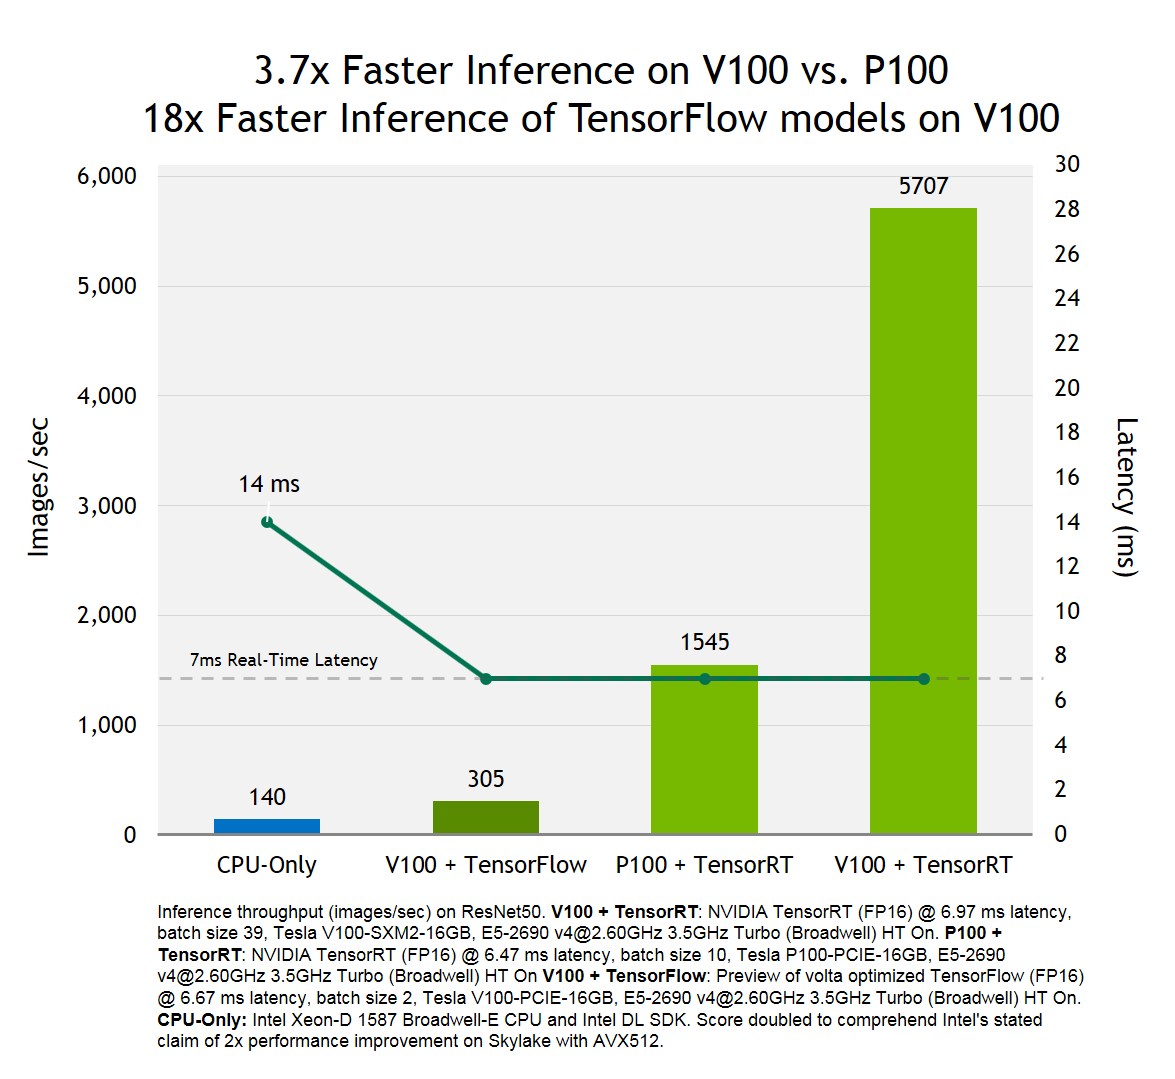




- CoreML。 CoreML是苹果公司提供的推理框架，可以用在运行macOS、iOS和watchOS的设备上部署模型，同样有着很好的效果。相对于TensorRT，CoreML的接口设计、编程语言和文档都非常友好。
Core ML 实时分类器：[Core ML Real-time Classifier Demo](https://github.com/Meirtz/Core-ML-Real-time-Classifier-Demo)
### 使用专用于推理的硬件
- NVIDIA Jetson。Jetson是NVIDIA公司推出的专用于部署深度学习模型的嵌入式设备，其大小只有一张信用卡这么大，包含一个Kepler或者Pascal架构的GPU。用于无人驾驶汽车的Drive PX还有多个Volta GPU。
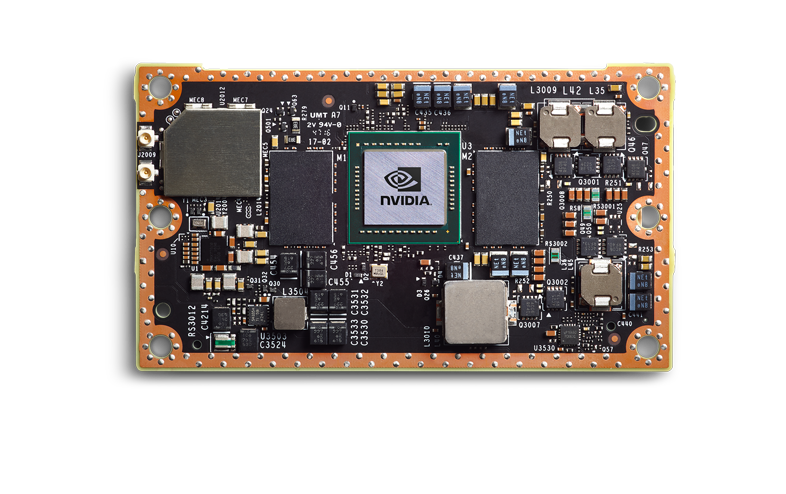

- Apple A11 Bionic和麒麟970芯片。苹果和华为都推出了具有神经元网络单元的手机CPU，同样可以加速神经网络的推理。